In [1]:
!git clone https://github.com/ahmed-h-elsheikh/polychaos-learn

fatal: destination path 'polychaos-learn' already exists and is not an empty directory.


In [2]:
# polychaos: deg -->, until mem brake
# 5, 10k - same
# hermite phys, prob (x, t - legendre)

In [3]:
# generate normal (uniform[-1, 1])features --> input model --> polycahos input = (x, t)
# normal (hermite prob) perm 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import random
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.preprocessing import StandardScaler

from pclearn import OrthogonalPolynomialsFeatures
from diffusion_equation import compute_solution
import torch

In [65]:
# # configuration of simulator
# # and parametrs of reservouir
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3


# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
# dt = 3.0 / 100
# niter = 100

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))


# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [66]:
# # configuration of simulator
# # and parametrs of reservouir
# perm = np.load('/Users/kirill/edu/3course/PINN_project/TwoPhase2/perm.npy')
# nx0, nx1 = perm.shape
# nx2 = 1
# perm = np.reshape(perm, (nx0, nx1, nx2))
# poro = 0.1 + np.zeros((nx0, nx1, nx2))

# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3

# pmin = 0.0
# pmax = 1.0

# niter = 5000
# t_final = 3.0
# dt = t_final / niter

In [46]:
# 2000
sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
sim_data, x_list, y_list, t_list

(array([[ 1.8131275e-01, -3.0602521e-34,  1.0000000e+00],
        [ 1.3059621e-01, -9.4923722e-34,  1.0000000e+00],
        [ 7.5577617e-01,  3.6256355e-01,  6.3743645e-01],
        ...,
        [ 4.7788918e-01, -4.1978276e-34,  1.0000000e+00],
        [ 4.4809765e-01,  2.6480693e-01,  7.3519307e-01],
        [ 3.8684043e-01, -7.8062762e-36,  1.0000000e+00]], dtype=float32),
 array([40., 41.,  6., ..., 25., 20., 30.], dtype=float32),
 array([14., 23., 10., ...,  6., 27., 15.], dtype=float32),
 array([0.6564166 , 2.7693186 , 1.9525808 , ..., 0.46080345, 2.6919582 ,
        0.2962337 ], dtype=float32))

In [45]:
# # 5000 3sigma
# sim_data = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/sim_5000.txt", dtype=np.float32)
# x_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/x_5000.txt", dtype=np.float32)
# y_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/y_5000.txt", dtype=np.float32)
# t_list = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k_3sigma/t_5000.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

(array([[ 4.3199003e-02,  6.6181231e-01,  3.3818772e-01],
        [ 1.4108596e-03,  3.6187479e-01,  6.3812524e-01],
        [ 3.3429716e-02,  5.5602217e-01,  4.4397783e-01],
        ...,
        [ 5.5982126e-03,  5.3862143e-01,  4.6137860e-01],
        [ 3.5300122e-03,  4.2821646e-01,  5.7178354e-01],
        [ 5.1515096e-01,  1.1274540e+01, -1.0274540e+01]], dtype=float32),
 array([10., 46., 14., ..., 19., 45.,  0.], dtype=float32),
 array([13., 28., 15., ..., 21., 27.,  8.], dtype=float32),
 array([4374., 4597., 2804., ..., 4569.,  648.,  248.], dtype=float32))

In [67]:
# # 5000
# sim_data_old = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/sim_5000.txt", dtype=np.float32)
# x_list_old = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/x_5000.txt", dtype=np.float32)
# y_list_old = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/y_5000.txt", dtype=np.float32)
# t_list_old = np.loadtxt("/Users/kirill/edu/3course/PINN_project/TwoPhase2/data_5k/t_5000.txt", dtype=np.float32)
# sim_data_old, x_list_old, y_list_old, t_list_old


# 5000
n_points = 500
rand_points = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[rand_points]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[rand_points]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[rand_points]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[rand_points]
sim_data, x_list, y_list, t_list

(array([[ 9.8710954e-01,  4.6469316e-01,  5.3530687e-01],
        [ 3.2836039e-02, -1.4340296e-35,  1.0000000e+00],
        [ 3.4733897e-01,  1.0638224e-36,  1.0000000e+00],
        ...,
        [ 7.7195847e-01, -2.1320558e-33,  1.0000000e+00],
        [ 3.2913671e-03, -1.7825270e-37,  1.0000000e+00],
        [ 8.9061010e-01,  3.1219782e-02,  9.6878022e-01]], dtype=float32),
 array([ 0., 60., 34.,  0., 40., 51.,  5., 15.,  1., 24., 62., 60., 41.,
        30., 48., 32., 14., 26., 24., 24.,  8.,  9., 32., 30., 62., 45.,
        50.,  7., 17., 36., 56., 28., 32., 59.,  6., 10., 10.,  8., 10.,
        32., 19., 44., 43.,  9.,  5., 63.,  7., 41., 16., 56., 14., 33.,
        55., 46., 22., 22., 32., 53., 23., 62., 42., 32., 62., 22., 10.,
        39., 30., 52., 50., 40., 53.,  2., 56.,  5.,  0., 34., 43., 51.,
        25., 18., 27.,  4., 44., 39., 51., 33., 26., 44., 37., 59., 62.,
        58., 11., 61., 41., 55., 63., 10., 43., 51., 58.,  2.,  6., 17.,
        55., 23., 15., 45., 47., 22., 

In [68]:
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2


# pwat1 = 2.0 * torch.ones_like(x).requires_grad_(True)
# poil1 = 4.0 * torch.ones_like(x).requires_grad_(True)
# kwat1 = 1.0 * torch.ones_like(x).requires_grad_(True)
# koil1 = 0.3 * torch.ones_like(x).requires_grad_(True)

# points = torch.stack((t, x, y), -1).requires_grad_(True)
points = np.stack((t_list * dt, x_list * dx0, y_list * dx1), -1)
# points_old = np.stack((t_list_old * dt, x_list_old * dx0, y_list_old * dx1), -1)
points, sim_data

(array([[2.1906002 , 0.        , 0.75      ],
        [0.25800002, 0.9375    , 0.109375  ],
        [0.70680004, 0.53125   , 0.921875  ],
        ...,
        [2.3046    , 0.28125   , 0.28125   ],
        [0.3054    , 0.984375  , 0.5       ],
        [2.9442    , 0.125     , 0.0625    ]], dtype=float32),
 array([[ 9.8710954e-01,  4.6469316e-01,  5.3530687e-01],
        [ 3.2836039e-02, -1.4340296e-35,  1.0000000e+00],
        [ 3.4733897e-01,  1.0638224e-36,  1.0000000e+00],
        ...,
        [ 7.7195847e-01, -2.1320558e-33,  1.0000000e+00],
        [ 3.2913671e-03, -1.7825270e-37,  1.0000000e+00],
        [ 8.9061010e-01,  3.1219782e-02,  9.6878022e-01]], dtype=float32))

In [69]:
def fix_random_seed(seed_):
    random.seed(seed_)
    np.random.seed(seed_)

In [70]:
norm = StandardScaler()
norm.fit_transform(points)

array([[ 0.8189187 , -1.6401134 ,  0.96227866],
       [-1.4407605 ,  1.4914677 , -1.2875745 ],
       [-0.9160042 ,  0.13444921,  1.5658978 ],
       ...,
       [ 0.9522122 , -0.70063907, -0.6839554 ],
       [-1.3853383 ,  1.6480467 ,  0.08428719],
       [ 1.7000601 , -1.2225692 , -1.452198  ]], dtype=float32)

In [71]:
rand_seed_ = 123456  # random.randint(1, 10000)  # fix seed randomly
fix_random_seed(rand_seed_)


# load data set
X_train, X_test, y_train, y_test = train_test_split(points, sim_data, test_size=0.3, random_state=rand_seed_)
# X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(points_old, sim_data_old, 
#                                                                     test_size=0.3, random_state=rand_seed_)

n_samples_train, n_features = X_train.shape

print('Working on training data of size {} and test data of size {}'.format(X_train.shape[0], X_test.shape[0]))
print('Number of features {}'.format(X_train.shape[1]))

Working on training data of size 350 and test data of size 150
Number of features 3


In [72]:
# define solver parameters
tol_eps = 1.0e-6  # tolerance
n_cv_folds = 5
alphas = np.logspace(-5, 1, 5)
l1_ratio = np.linspace(0.05, 0.95, 10)
n_max_iter = 1000  # number of iteratons

fitting_method = MultiTaskElasticNetCV(l1_ratio=l1_ratio, alphas=alphas,
                              max_iter=n_max_iter, tol=tol_eps, cv=n_cv_folds,
                              fit_intercept=False, selection='random')

# define interpolation parameters
poly_degree = 20  # degree of polynomial

# hermite
# input normal ---> std scale
# u[-1, 1] legendre, expon laguerre

poly_type = ['legendre'] * n_features  # could be different e.g. ['legendre', 'hermite']

reduction = False # ok
dlist = []
truncated_dim = 20
single_iter_dim = 10
niter = 1000
nrand = 50

t_start = time.time()
orthopoly = OrthogonalPolynomialsFeatures(
    degree=poly_degree, dlist=dlist, poly_type=poly_type,
    reduction=reduction, basis_dim=truncated_dim,
    single_iter_dim=single_iter_dim, niter=niter, nrand=nrand,
    clf=fitting_method)
print('Calling OrthogonalPolynomialsFeatures in {:6f} seconds'.format(time.time() - t_start))

regression_pipeline = Pipeline(steps=[
    ('orthopoly', orthopoly),
    ('fitting_method', fitting_method)])

t_start = time.time()
regression_pipeline.fit(X_train, y_train)
print('Linear problem (with PCE basis) has been solved in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_train_pred = regression_pipeline.predict(X_train)
print('Prediction over the training data in {:6f} seconds'.format(time.time() - t_start))

t_start = time.time()
y_test_pred = regression_pipeline.predict(X_test)
print('Prediction over the test data in {:6f} seconds'.format(time.time() - t_start))

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print('MSE train: {} vs. test {}'.format(mse_train, mse_test))
y_train_pred

Calling OrthogonalPolynomialsFeatures in 0.000210 seconds
n_output_features: 1771


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.1380844116211, tolerance: 0.00036430321051739156
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.91004180908203, tolerance: 0.00036430321051739156
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.313850164413452, tolerance: 0.00036430321051739156
  mod

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02517392858862877, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.90823364257812, tolerance: 0.00036430321051739156
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.466373443603516, tolerance: 0.00036430321051739156
 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21424153447151184, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029444409534335136, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.19388580322266, tolerance: 0.00036430321051739156


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.70346736907959, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26722750067710876, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03354068472981453, tolerance: 0.0003667765995487571
  mo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.436336517333984, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.168008804321289, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31022125482559204, tolerance: 0.0003667765995487571
  mo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.58476257324219, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.25889205932617, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.584988117218018, tolerance: 0.0003667765995487571
  mode

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04740408807992935, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.45905303955078, tolerance: 0.0003667765995487571
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.55434799194336, tolerance: 0.0003667765995487571
  m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4526408910751343, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050725582987070084, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.68089294433594, tolerance: 0.0003667765995487571


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.850076198577881, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49283894896507263, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054660044610500336, tolerance: 0.00036389537854120135

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.67675018310547, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.180031776428223, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5292367339134216, tolerance: 0.00036389537854120135
  m

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.40518951416016, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.02850341796875, tolerance: 0.00036389537854120135
  model = cd_fast.enet_coordinate_descent_multi_task(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4990644454956055, tolerance: 0.00036389537854120135
  

Linear problem (with PCE basis) has been solved in 101.892058 seconds
Prediction over the training data in 0.133500 seconds
Prediction over the test data in 0.185018 seconds
MSE train: 0.0014760087942704558 vs. test 0.004151479806751013


array([[ 0.8200547 ,  0.0145729 ,  0.96269375],
       [ 0.63119495, -0.01431808,  1.0118324 ],
       [ 0.01428743,  0.0089594 ,  0.9897329 ],
       ...,
       [ 0.06114641, -0.00118552,  0.97959924],
       [ 0.23257953, -0.00407927,  1.014801  ],
       [ 0.35402694, -0.00408072,  1.0009662 ]], dtype=float32)

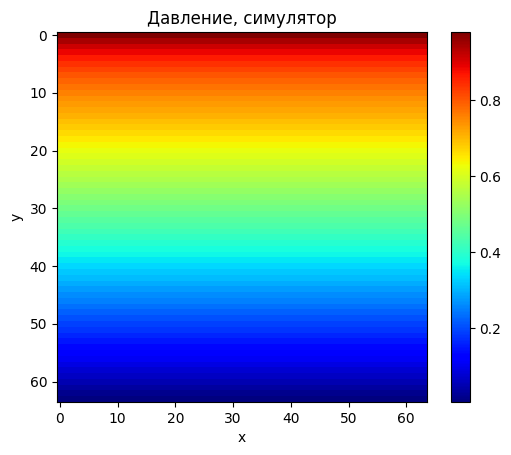

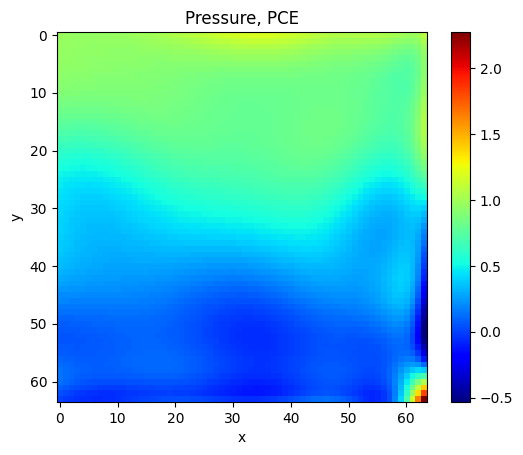

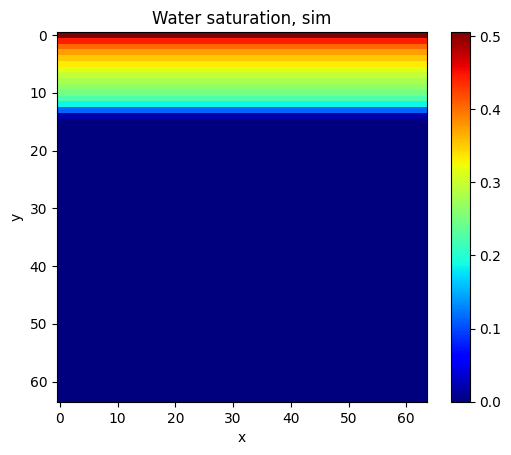

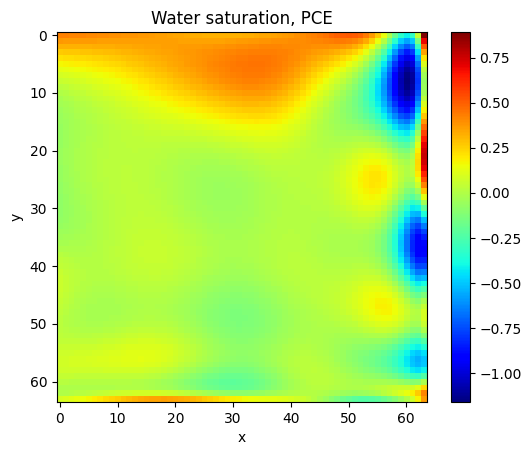

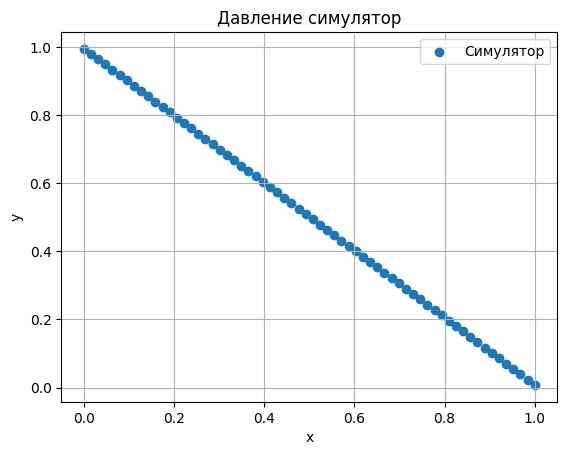

In [73]:
pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3
pmin = 0.0
pmax = 1.0
nx0 = 64
nx1 = 64
nx2 = 1
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2
dt = 0.26e-1
niter = 100

poro = 0.1 + np.zeros((nx0, nx1, nx2))
perm = np.load('perm.npy')

pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, dt * niter, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * np.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
cartesian_points = cartesian_points.detach().numpy()
model_prediction = regression_pipeline.predict(np.stack((time_for_model, 
                                                              cartesian_points[:, 0], 
                                                              cartesian_points[:, 1]), -1))


plt.figure()
plt.title('Давление, симулятор')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_pres_sim.png')
plt.show()

plt.figure()
plt.title('Pressure, PCE')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_tree_pres.png')
plt.show()



plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Water saturation, PCE')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('color_tree_swat.png')
plt.show()



plt.figure()
plt.title('Давление симулятор')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, 3], label='Симулятор')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [53]:
norm.transform(np.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))

array([[98.72150703, -1.77436058, -1.64609357],
       [98.72150703, -1.77436058, -1.52922502],
       [98.72150703, -1.77436058, -1.41235647],
       ...,
       [98.72150703,  1.6730489 ,  1.50935732],
       [98.72150703,  1.6730489 ,  1.62622596],
       [98.72150703,  1.6730489 ,  1.7430944 ]])

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [77]:
model_pred_train.shape

(500, 3)

In [78]:
model_pred_train = regression_pipeline.predict(points)

In [79]:
satur = [mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]),
         mean_absolute_error(sim_data[:, 1], model_pred_train[:, 1]),
         r2_score(sim_data[:, 1], model_pred_train[:, 1]),
         np.sqrt(mean_squared_error(sim_data[:, 1], model_pred_train[:, 1]))]

pres_train = [mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]),
         mean_absolute_error(sim_data[:, 0], model_pred_train[:, 0]),
         r2_score(sim_data[:, 0], model_pred_train[:, 0]),
         np.sqrt(mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]))]

In [80]:
metrics_train = pd.DataFrame({'Saturation': satur, 'Pressure': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])

In [81]:
metrics_train

,Saturation,Pressure
MSE,0.002245,0.002057
MAE,0.022651,0.028261
R^2,0.741827,0.982704
RMSE,0.047379,0.045353
